# Day 1

1. How might mixing the baskets with different kinds of data affect compression of the data upon filling the tree and saving to file? Does this have an effect with the overall disk usage or CPU walltime?

~~Mixing different kinds of data could affect compression because different kinds of data have different patterns/statistical properties. That said, something like `zlib` would usually flush out the internal structures it uses to track those patterns every so often specifically to account for those patterns changing over time. So if you had a dataset that was, say, lines of text representing phone numbers and lines of text representing addresses, you would get your most ideal compression if you had all of the phone numbers come before all of the addresses (or vice versa), and the more the phone number and addresses are interleaved, the worse compression would become.~~

~~It's very much like cache misses -- the compressor is looking for patterns its seen before, and it only has so much space to store those patterns, so ideally you'd want all the data associated with one set of patterns to be processed, and then all the data with another set of patterns, and so on.~~

~~CPU walltime could also increase because the compressor has to do more work -- getting back to the cache misses analogy, it takes more time for the compressor to record a new pattern than to refer back to a pattern its already seen. If the a particular pattern keeps getting flushed out only to be encountered again later, then redundant work is being done.~~

~~*This is all assuming a Lempel-Ziv based compressor, which `zlib` is, and of course that's the ROOT default, so...~~
~~**Also this is really only looking at one step of what happens in a compression pipeline, but it is the actual compression part.~~

OK all of the above is *true* but probably not quite the answer to this question. 

"Compressability", especially in the context of lossless compression, really just boils down to how much repetition exists in the data. Repeated patterns are recorded and encoded in some more concise representation. This means that truly random data is not compressable at all -- there is no meaningful repetition in it. On the other hand, repetitive data is compressable, and the more repetitive the data is, the more compressable it is.

*However*, part of what allows data to be more or less repetitive is how many values that data can conceivably take. A `char` is only 1 byte, and can only encode 256 unique values. A 64-bit `double` can represent 18,446,744,073,709,551,616 unique values. Obviously it is more likely that we will repeat any given `char` (or sequence of `char`s) than any given `double` (or sequence of `double`s), even if the `char` data and `double` data are both truly random. (Basically, how some infinities are bigger than other infinities -- some randomness is more random than other randomness.)

So even without knowing what the data is, we can expect that some data types are more compressable than other data types. Mixing more compressable data with less compressable data would result in worse compression overall, and therefore higher disk usage. 

CPU wall time is... harder to predict? I want to say that less compressable data also takes longer to compress, because new patterns keep having to be recorded, making more work for the compressor. But in my experience with `zlib`, the data that takes the longest to compress hits a balance between complexity and repetitiveness.

---

2. Plot some of the histograms by calling back to the original hvector tutorial.

I used the macro `plots.C` to plot each branch of `hvector_1000000_F0_Bsz0_Vsz50.root`, creating the plots `vpxHist.png`, `vpyHist.png`, `vpzHist.png`, `vptHist.png`, `vpintHist.png`

![](vpxHist.png) ![](vpyHist.png)

`px` and `py` are distributed as normal distributions with mean=0 and sigma=1, which is exactly how we defined them.

![](vptHist.png)

We defined $pt = \sqrt{px^2 + py^2}$ and then double-counted `pt`; accordingly, it's distribution has no negative values and is skewed right.

![](vpzHist.png)

`vpz` is a uniformly distributed value between 0 and 1.

![](vpintHist.png)

`vpint` has a discretized normal-ish distribution, centered around ~50. This results from transforming and then discretizing a uniform random distribution between 0 and 1.

---

3. Once you have these, using tree->SetBasketSize(X), set the size of the basket buffer to values in this set: {4, 8, 16,
32, 64, 128, 256, 512, 1024} [kB] and take the corresponding compression factors of an individual branch (You can
obtain this a couple ways, within the script or after the .root file is written). After this is written, plot the compression
factors according to the basket sizes.
    
    a. Do this first with only random floating point numbers. After you get this, then you can fill the branches with (½
    easily-compressible and ½ difficult-to-compress) numbers and see how that changes things.

    b. What do you notice with the smaller basket sizes? The larger ones?

    c. Do the benchmarks tell us anything useful? 

In [6]:
# Data from "writeROOTFile_Baskets_*.out"
branches = ["VpxVpy", "VpxVpyVpz", "VpxVpyVpzVpt", "VpxVpyVpzVptVpint"]
basketSizes = [4, 8, 16, 32, 64, 128, 256, 512, 1024]

data = {
    'vpx': {
        'VpxVpy': 9 * [1.02],
        'VpxVpyVpz': 9 * [1.03],
        'VpxVpyVpzVpt': 9 * [1.06],
        'VpxVpyVpzVptVpint': 9 * [1.07]
    },
    'vpy': {
        'VpxVpy': 9 * [1.02],
        'VpxVpyVpz': 9 * [1.03],
        'VpxVpyVpzVpt': 9 * [1.06],
        'VpxVpyVpzVptVpint': 9 * [1.07]
    },
    'vpz': {
        'VpxVpy': 9 * [None],
        'VpxVpyVpz': 9 * [1.06],
        'VpxVpyVpzVpt': 9 * [1.09],
        'VpxVpyVpzVptVpint': 9 * [1.09]
    },
    'vpt': {
        'VpxVpy': 9 * [None],
        'VpxVpyVpz': 9 * [None],
        'VpxVpyVpzVpt': 9 * [1.64],
        'VpxVpyVpzVptVpint': 6 * [1.66] + 2 * [1.65] + [1.66]
    },
    'vpint': {
        'VpxVpy': 9* [None],
        'VpxVpyVpz': 9 * [None],
        'VpxVpyVpzVpt': 9 * [None],
        'VpxVpyVpzVptVpint': 9 * [2.38]
    },
    'tree': {
        'compression': {
            'VpxVpy': 9 * [1.02],
            'VpxVpyVpz': 9 * [1.04],
            'VpxVpyVpzVpt': 9 * [1.24],
            'VpxVpyVpzVptVpint': 9 * [1.35]
        },
        'time': {
            'real': {
                'VpxVpy': [17.53, 16.93, 17.01, 16.96, 17.02, 17.03, 17.26, 17.29, 17.14],
                'VpxVpyVpz': [22.87, 22.62, 22.75, 22.74, 22.58, 22.50, 22.93, 24.08, 24.36],
                'VpxVpyVpzVpt': [30.07, 29.76, 29.75, 30.05, 30.02, 29.47, 29.50, 29.51, 29.29],
                'VpxVpyVpzVptVpint': [34.66, 33.61, 34.44, 33.03, 32.15, 32.20, 32.05, 32.65, 32.39],
            },
            'cpu': {
                'VpxVpy': [17.24, 16.80, 16.92, 16.84, 16.81, 16.85, 16.90, 17.09, 16.99],
                'VpxVpyVpz': [22.72, 22.44, 22.55, 22.46, 22.30, 22.21, 22.65, 23.77, 24.07],
                'VpxVpyVpzVpt': [29.75, 29.72, 29.46, 30.02, 29.89, 29.27, 29.34, 29.42, 29.18],
                'VpxVpyVpzVptVpint': [34.27, 33.35, 34.37, 32.96, 31.87, 32.17, 32.03, 32.31, 32.06]
            }
        }
    }
}

In [7]:
import pandas as pd

def dictToDataFrame(data, branchName, valueName):
    df = pd.DataFrame(data)
    df['branch'] = branchName
    df['basketSize'] = basketSizes
    return df.melt(id_vars=['branch', 'basketSize'], var_name='branchesInTree', value_name=valueName)

dfx = dictToDataFrame(data['vpx'], 'vpx', 'compression')
dfy = dictToDataFrame(data['vpy'], 'vpy', 'compression')
dfz = dictToDataFrame(data['vpz'], 'vpz', 'compression')
dft = dictToDataFrame(data['vpt'], 'vpt', 'compression')
dfint = dictToDataFrame(data['vpint'], 'vpint', 'compression')
dftreecomp = dictToDataFrame(data['tree']['compression'], 'tree', 'compression')
dftreetimereal = dictToDataFrame(data['tree']['time']['real'], 'tree', 'realTime')
dftreetimecpu = dictToDataFrame(data['tree']['time']['cpu'], 'tree', 'cpuTime')

df = pd.concat([dfx, dfy, dfz, dft, dfint, dftreecomp, dftreetimereal, dftreetimecpu], ignore_index=True)
df.basketSize = df.basketSize.astype(str) + ' kB'
df

,branch,basketSize,branchesInTree,compression,realTime,cpuTime
0,vpx,4 kB,VpxVpy,1.02,NaN,NaN
1,vpx,8 kB,VpxVpy,1.02,NaN,NaN
2,vpx,16 kB,VpxVpy,1.02,NaN,NaN
3,vpx,32 kB,VpxVpy,1.02,NaN,NaN
4,vpx,64 kB,VpxVpy,1.02,NaN,NaN
...,...,...,...,...,...,...
283,tree,64 kB,VpxVpyVpzVptVpint,NaN,NaN,31.87
284,tree,128 kB,VpxVpyVpzVptVpint,NaN,NaN,32.17
285,tree,256 kB,VpxVpyVpzVptVpint,NaN,NaN,32.03
286,tree,512 kB,VpxVpyVpzVptVpint,NaN,NaN,32.31


Text(0, 0.5, 'Compression Ratio')

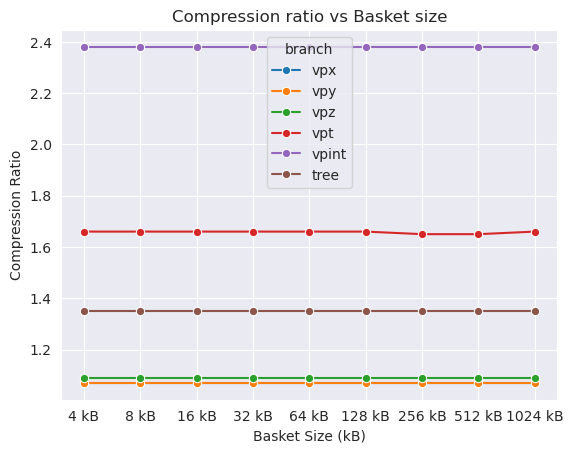

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

# Plot compression vs basket size
ax = sns.lineplot(data=df[df['branchesInTree'] == 'VpxVpyVpzVptVpint'], x='basketSize', y='compression', hue='branch', marker='o')
ax.set_title('Compression ratio vs Basket size')
ax.set_xlabel('Basket Size (kB)')
ax.set_ylabel('Compression Ratio')

The above graph shows that basket size really doesn't make a difference to compression ratio. It also confirms our assumptions about easy-to-compress vs hard-to-compress data:
- `vpy` and `vpx` are totally random float data, and least compressable (`vpx` is hidden by `vpy`)
- `vpz` is only slightly more compressed than `vpy` and `vpx` -- this data is also random floats, but in a smaller range than `vpy` and `vpx`
- `vpt` is second-most-compressed. This is float data that is *derived* from random float data, and that additional structure (and, again, smaller range) make it more compressable.
- `vpint` is the most compressable. These are random integers between 0 and 100, and take on the fewest possible values.
- `tree` is the overall compression ratio of the tree. This is the size of the uncompressed data (bytes) / size of the compressed data (bytes). The tree's compression ratio is weighted more toward the compression ratios of the floats because they make up more of the bytes -- there are more floats in the tree, and the floats are larger than the ints. 

Text(0, 0.5, 'Compression Ratio')

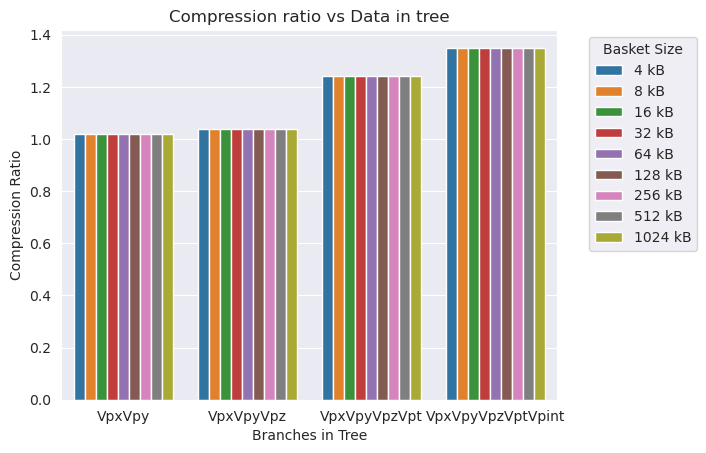

In [15]:
# Plot compression vs branches in tree
ax = sns.barplot(data=df[df['branch'] == 'tree'], x='branchesInTree', y='compression', hue='basketSize')
ax.legend(title='Basket Size', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('Compression ratio vs Data in tree')
ax.set_xlabel('Branches in Tree')
ax.set_ylabel('Compression Ratio')

The above plot shows that while basket size does not change the compressability of the tree, the type of data in the tree does. This seems like a fairly obvious observation -- if a tree is only full of poorly compressable data, the compressability of the tree will be lower than if it has a mix of poorly compressable and decently compressable data. But! There's more to it.

Text(0, 0.5, 'Compression Ratio')

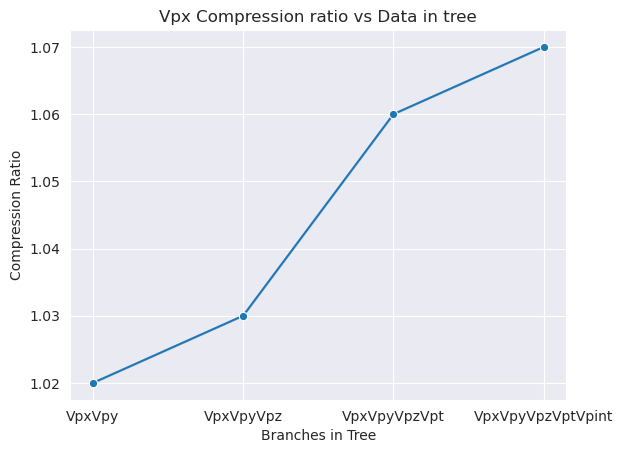

In [ ]:
# Plot vpx compress vs branches in tree
ax = sns.lineplot(data=df[df['branch'] == 'vpx'], x='branchesInTree', y='compression', marker='o')
ax.set_title('Vpx Compression ratio vs Data in tree')
ax.set_xlabel('Branches in Tree')
ax.set_ylabel('Compression Ratio')

Adding branches with more compressable data improves the compression ratio of data with low compressability! That's... weird!

My understanding has been that branches are compressed independently of each other, so this... complicates things. I really don't know what to make of it off the top of my head.

---

# Day 2